In [9]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 7.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

train_df = pd.read_csv("/kaggle/input/weather-data-normalized/weather_train.csv")
train_df.head(14)

,Date,Time,Weather,Temp,Rain,Cloud,Pressure,Wind
0,2009-01-01,00:00,patchy rain possible,-2.019447,1.604436,1.423837,1.718056,1.279488
1,2009-01-01,03:00,moderate rain at times,-1.814438,1.924270,1.423837,1.718056,1.677434
2,2009-01-01,06:00,heavy rain at times,-2.019447,2.033752,1.423837,1.718056,1.416617
3,2009-01-01,09:00,moderate rain at times,-1.814438,2.008139,1.423837,2.043605,1.677434
4,2009-01-01,12:00,moderate rain at times,-2.019447,1.973087,1.423837,1.718056,1.279488
5,2009-01-01,15:00,moderate rain at times,-2.019447,1.973087,1.423837,1.555282,1.279488
6,2009-01-01,18:00,patchy rain possible,-2.224457,1.604436,1.423837,1.718056,0.835818
7,2009-01-01,21:00,patchy rain possible,-2.019447,1.011483,1.423837,2.043605,1.279488
8,2009-01-02,00:00,patchy rain possible,-1.814438,1.011483,1.423837,1.880831,0.989629
9,2009-01-02,03:00,moderate rain at times,-1.814438,1.854939,1.423837,1.718056,1.279488


In [3]:
def process_data(df):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Keep only datetime and temperature columns
    df = df[['datetime', 'Temp']].copy()
    df.columns = ['ds', 'y']

    # Set 3-hour frequency
    df.set_index('ds', inplace=True)
    df = df.asfreq('3h').reset_index()

    # Add the unique_id required by StatsForecast
    df['unique_id'] = 'temp_series'

    # Reorder columns for StatsForecast
    df = df[['unique_id', 'ds', 'y']]

    return df

In [4]:
train_df = process_data(train_df)
train_df

,unique_id,ds,y
0,temp_series,2009-01-01 00:00:00,-2.019447
1,temp_series,2009-01-01 03:00:00,-1.814438
2,temp_series,2009-01-01 06:00:00,-2.019447
3,temp_series,2009-01-01 09:00:00,-1.814438
4,temp_series,2009-01-01 12:00:00,-2.019447
...,...,...,...
37979,temp_series,2021-12-31 09:00:00,-1.404419
37980,temp_series,2021-12-31 12:00:00,-1.404419
37981,temp_series,2021-12-31 15:00:00,-1.404419
37982,temp_series,2021-12-31 18:00:00,-1.404419


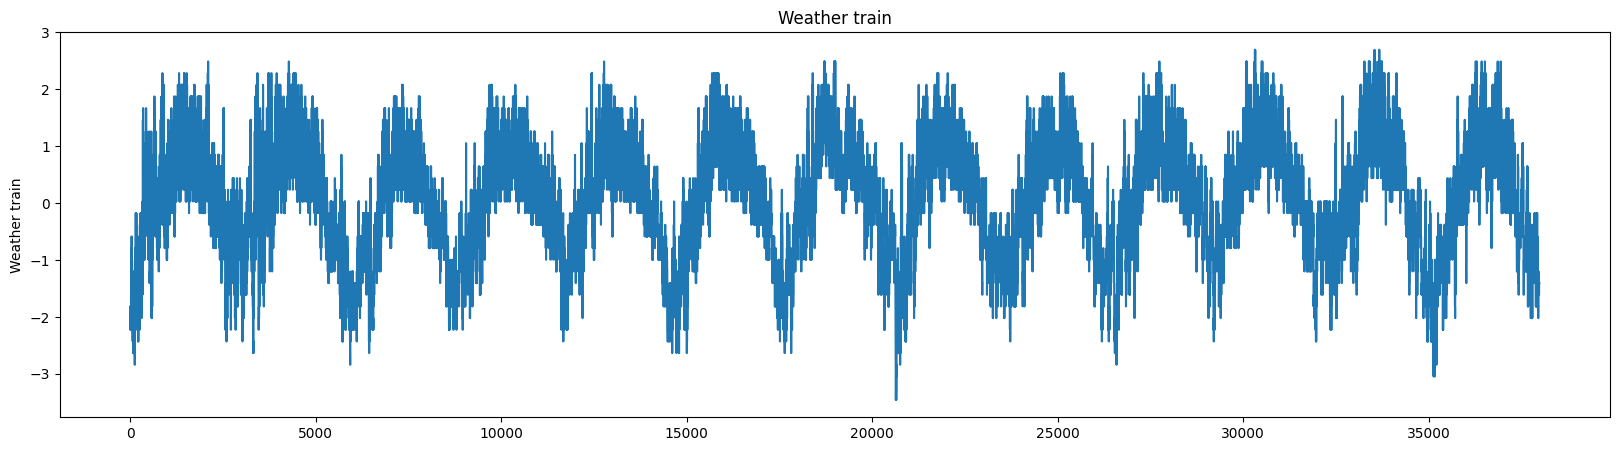

In [5]:
import matplotlib.pyplot as plt

train_df['y'].plot(figsize=(20, 5), title='Weather train')
plt.ylabel("Weather train")
plt.show()

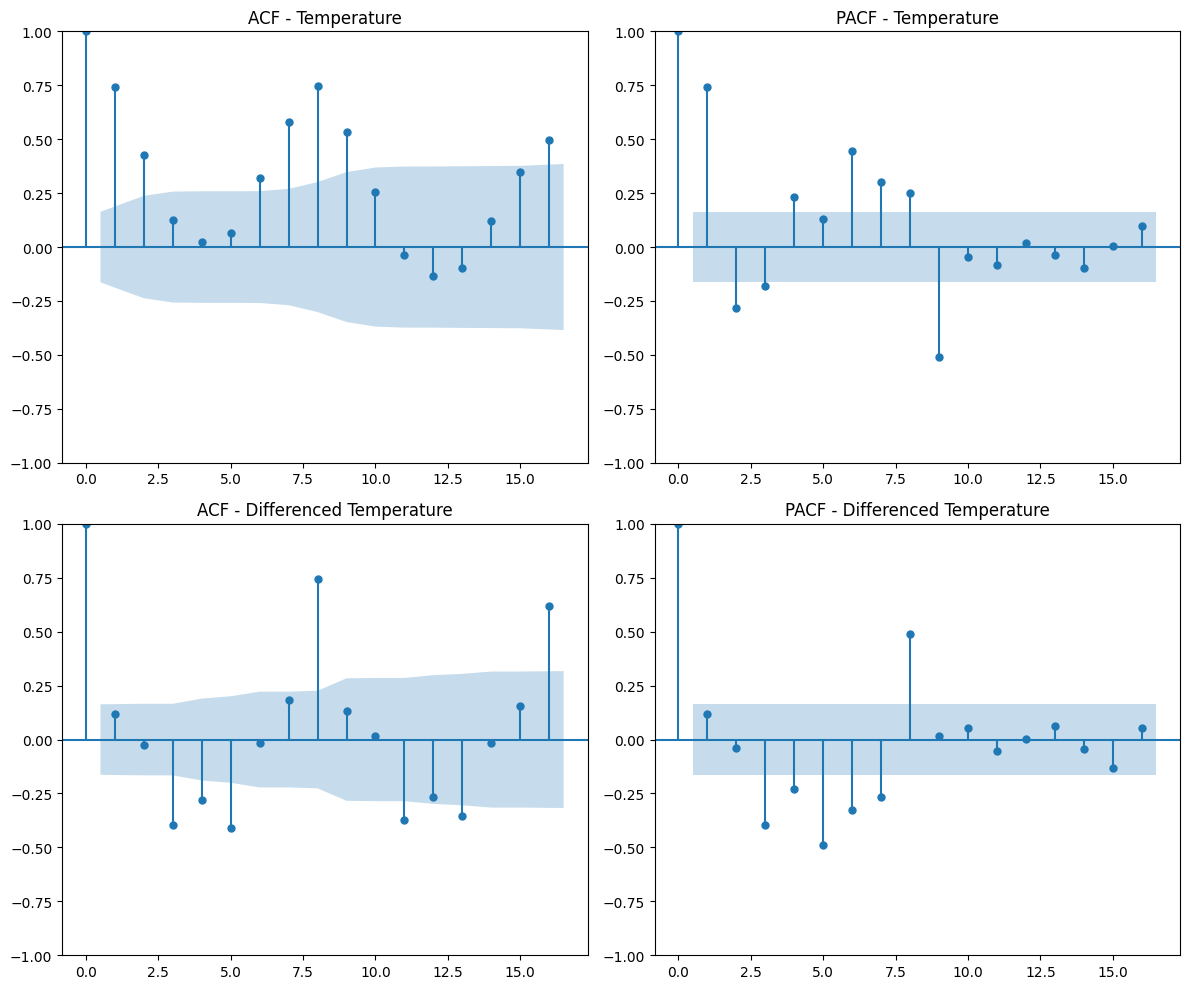

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
train_df["diff"] = train_df["y"].diff()

temp_series = train_df['y'][-31*8:].dropna()
diff_series = train_df['diff'][-31*8:].dropna()

max_lags = 8*2

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ACF của temp
plot_acf(temp_series, ax=axes[0, 0], lags=max_lags, alpha=0.01)
axes[0, 0].set_title('ACF - Temperature')

# PACF của temp
plot_pacf(temp_series, ax=axes[0, 1], lags=max_lags, method='ywm', alpha=0.01)
axes[0, 1].set_title('PACF - Temperature')

# ACF của diff
plot_acf(diff_series, ax=axes[1, 0], lags=max_lags, alpha=0.01)
axes[1, 0].set_title('ACF - Differenced Temperature')

# PACF của diff
plot_pacf(diff_series, ax=axes[1, 1], lags=max_lags, method='ywm', alpha=0.01)
axes[1, 1].set_title('PACF - Differenced Temperature')

plt.tight_layout()
plt.show()

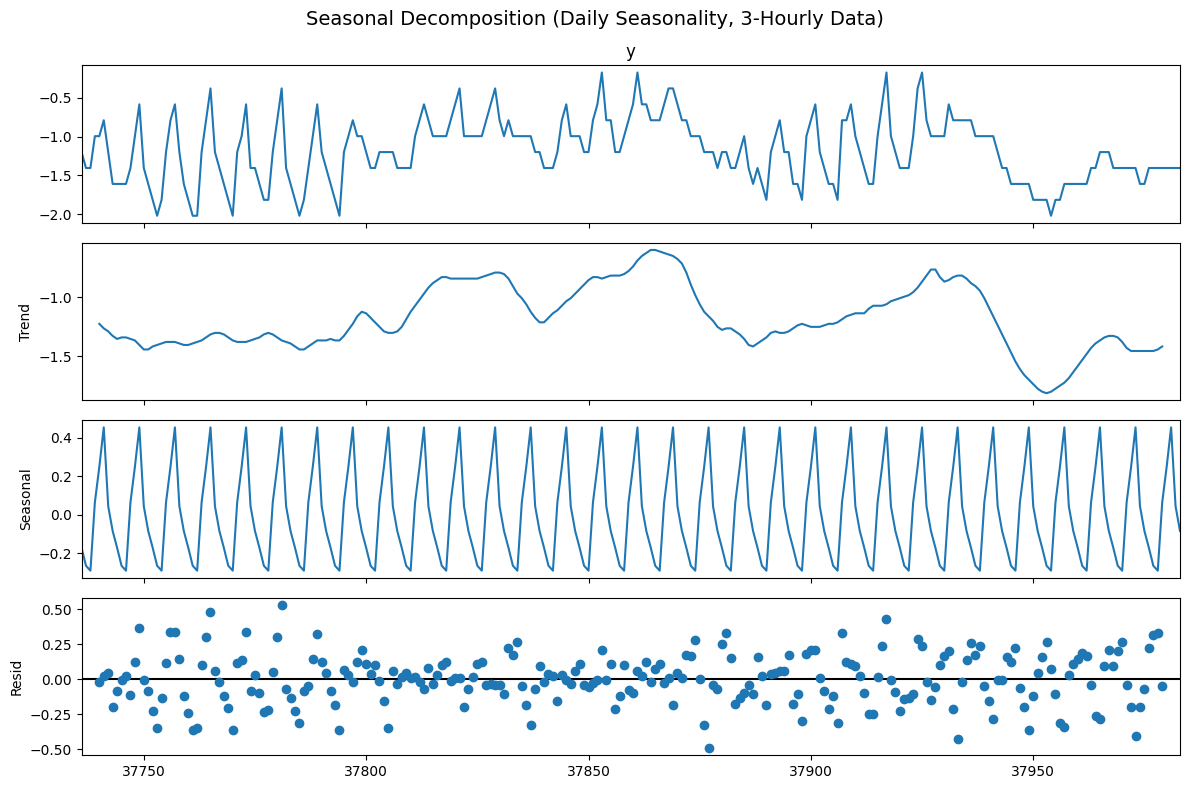

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 8 time steps per day => seasonal_period = 8 for daily seasonality

result = seasonal_decompose(train_df['y'][-31*8:].dropna(), model='additive', period=8)

# Plot decomposition
fig = result.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition (Daily Seasonality, 3-Hourly Data)", fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
train_df = train_df.drop(columns=["diff"])

In [17]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

season_length = 8

sf = StatsForecast(
    models=[AutoARIMA(
        seasonal=True,
        season_length=season_length,
        start_p=1, start_q=1,
        max_p=3, max_q=3,
        start_P=1, start_Q=1,
        max_P=2, max_Q=2,
        d=None, D=None,
        trace=True,
        stepwise=True,
    )],
    freq='3h',
)
sf.fit(df=train_df)


ARIMA(1,0,1)(1,1,1)[8] with drift        :inf

ARIMA(0,0,0)(0,1,0)[8] with drift        :28291.403034418436

ARIMA(1,0,0)(1,1,0)[8] with drift        :-12799.629841673122

ARIMA(0,0,1)(0,1,1)[8] with drift        :5139.295087575774

ARIMA(0,0,0)(0,1,0)[8]                   :28289.407571340747

ARIMA(1,0,0)(0,1,0)[8] with drift        :-7668.393334720187

ARIMA(1,0,0)(2,1,0)[8] with drift        :-14920.352354532122

ARIMA(1,0,0)(2,1,1)[8] with drift        :inf

ARIMA(1,0,0)(1,1,1)[8] with drift        :inf

ARIMA(0,0,0)(2,1,0)[8] with drift        :27466.361916866626

ARIMA(2,0,0)(2,1,0)[8] with drift        :-14921.743030729174

ARIMA(2,0,0)(1,1,0)[8] with drift        :-12799.293140712281

ARIMA(2,0,0)(2,1,1)[8] with drift        :inf

ARIMA(2,0,0)(1,1,1)[8] with drift        :inf

ARIMA(3,0,0)(2,1,0)[8] with drift        :-14922.198200566989

ARIMA(3,0,0)(1,1,0)[8] with drift        :-12797.375840192975

ARIMA(3,0,0)(2,1,1)[8] with drift        :inf

ARIMA(3,0,0)(1,1,1)[8] with dr

StatsForecast(models=[AutoARIMA])

In [18]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(3,0,2)(2,1,0)[8] with drift        '

In [19]:
from statsforecast.models import ARIMA

sf = StatsForecast(models=[ARIMA(order=(3, 0, 2), seasonal_order=(2, 1, 0), season_length=8)], freq='3h')

In [21]:
crossvalidation_df = sf.cross_validation(df=train_df,
                                         h=8,
                                         step_size=8,
                                         n_windows=10)

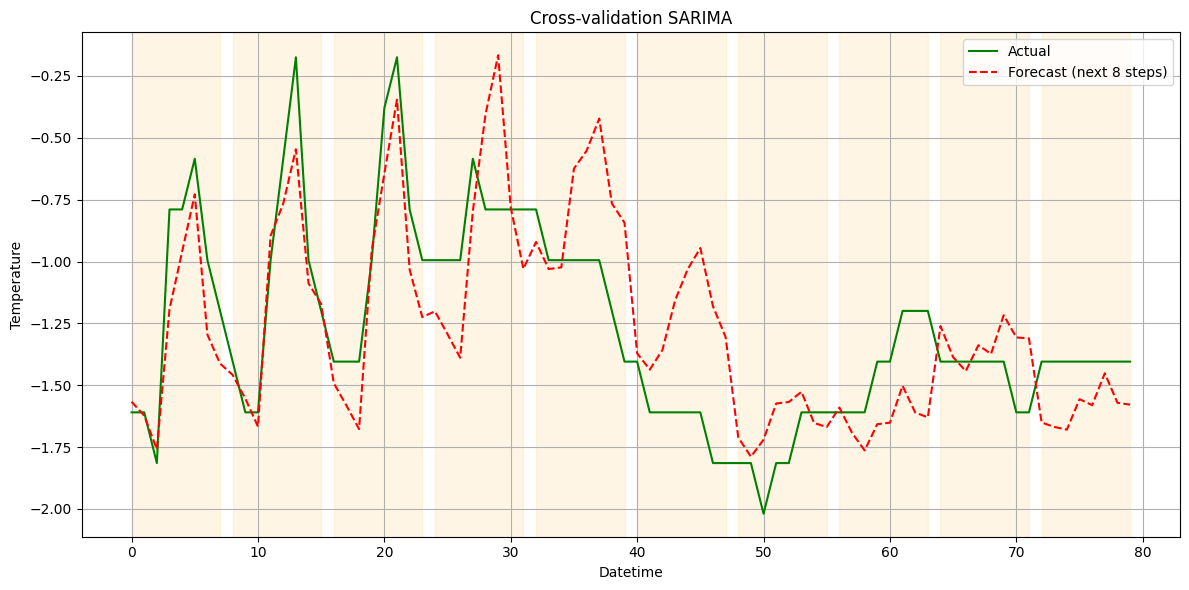

In [22]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12, 6))

# Plot last 16 actual values for context
plt.plot(crossvalidation_df.index, crossvalidation_df["y"], label='Actual', color='green')
# Plot the 8-step forecast
plt.plot(crossvalidation_df.index, crossvalidation_df["ARIMA"], label='Forecast (next 8 steps)', color='red', linestyle='--')

step_size = 8  # how many timesteps per forecast
for i in range(0, len(crossvalidation_df), 8):
    block = crossvalidation_df.index[i:i + step_size]
    if len(block) > 0:
        start, end = block[0], block[-1]
        plt.axvspan(start, end, color='orange', alpha=0.1)


plt.title("Cross-validation SARIMA")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
test_df = pd.read_csv("/kaggle/input/weather-data-normalized/weather_test.csv")
test_df = process_data(test_df)
test_df.head(14)

,unique_id,ds,y
0,temp_series,2022-01-01 00:00:00,-1.609428
1,temp_series,2022-01-01 03:00:00,-1.404419
2,temp_series,2022-01-01 06:00:00,-1.404419
3,temp_series,2022-01-01 09:00:00,-1.199410
4,temp_series,2022-01-01 12:00:00,-1.199410
5,temp_series,2022-01-01 15:00:00,-0.994400
6,temp_series,2022-01-01 18:00:00,-1.199410
7,temp_series,2022-01-01 21:00:00,-1.199410
8,temp_series,2022-01-02 00:00:00,-1.199410
9,temp_series,2022-01-02 03:00:00,-1.199410


In [24]:
forecast = sf.forecast(df=train_df, h=8, fitted=True)

In [26]:
forecast

,unique_id,ds,ARIMA
0,temp_series,2022-01-01 00:00:00,-1.320075
1,temp_series,2022-01-01 03:00:00,-1.371556
2,temp_series,2022-01-01 06:00:00,-1.366344
3,temp_series,2022-01-01 09:00:00,-1.333552
4,temp_series,2022-01-01 12:00:00,-1.365269
5,temp_series,2022-01-01 15:00:00,-1.306134
6,temp_series,2022-01-01 18:00:00,-1.371961
7,temp_series,2022-01-01 21:00:00,-1.379894


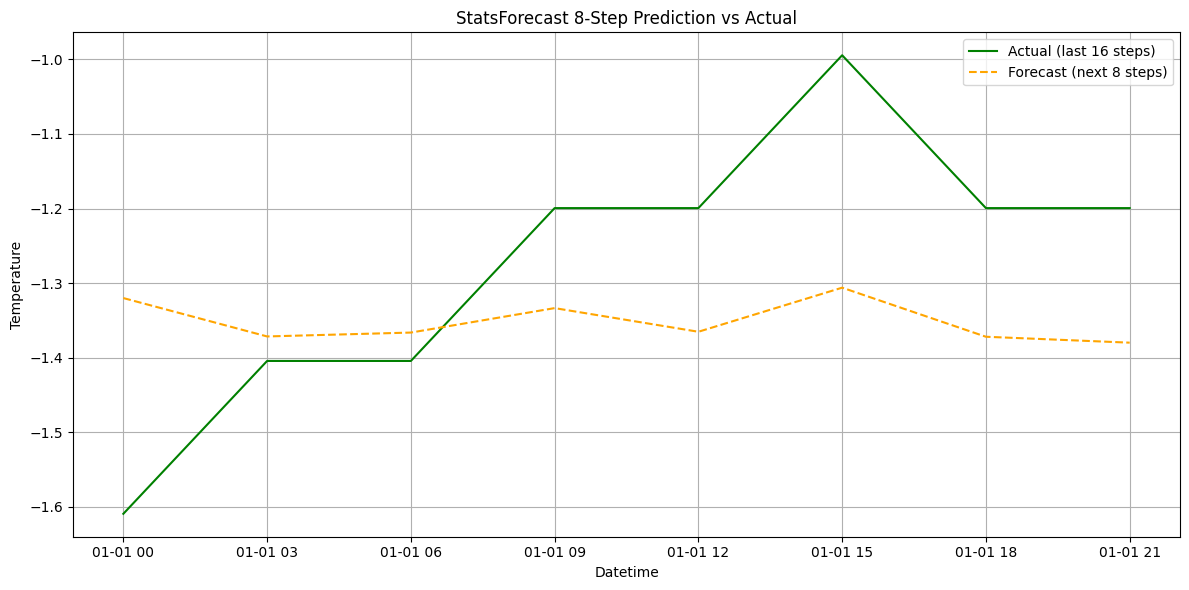

In [28]:
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(12, 6))

# Plot last 8 actual values for context
plt.plot(test_df[:8].ds, test_df["y"][:8], label='Actual (last 16 steps)', color='green')

# Plot the 8-step forecast
plt.plot(forecast.ds, forecast["ARIMA"], label='Forecast (next 8 steps)', color='orange', linestyle='--')

plt.title("StatsForecast 8-Step Prediction vs Actual")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [116]:
season_length = 8
sf = StatsForecast(
    models=[
        ARIMA(order=(3, 0, 2), seasonal_order=(2, 1, 0), season_length=season_length)
    ],
    freq='3h'
)

In [127]:
future = process_data(pd.read_csv("/kaggle/input/weather-data-normalized/weather_test.csv"))

In [30]:
history = train_df.copy()
future = test_df.copy() 
n_predicts = 20
all_forecasts = []
h = 8

for i in range(n_predicts):
    forecast = sf.forecast(df=history, h=h, fitted=False)
    all_forecasts.append(forecast)

    true_block = future.iloc[i * h : (i + 1) * h].copy()
    if len(true_block) == 0:
        break

    history = pd.concat([history, true_block], ignore_index=True)

In [31]:
final_forecasts = pd.concat(all_forecasts, ignore_index=True)

In [32]:
final_forecasts

,unique_id,ds,ARIMA
0,temp_series,2022-01-01 00:00:00,-1.320075
1,temp_series,2022-01-01 03:00:00,-1.371556
2,temp_series,2022-01-01 06:00:00,-1.366344
3,temp_series,2022-01-01 09:00:00,-1.333552
4,temp_series,2022-01-01 12:00:00,-1.365269
...,...,...,...
155,temp_series,2022-01-20 09:00:00,-1.542326
156,temp_series,2022-01-20 12:00:00,-1.503505
157,temp_series,2022-01-20 15:00:00,-1.365581
158,temp_series,2022-01-20 18:00:00,-1.526097


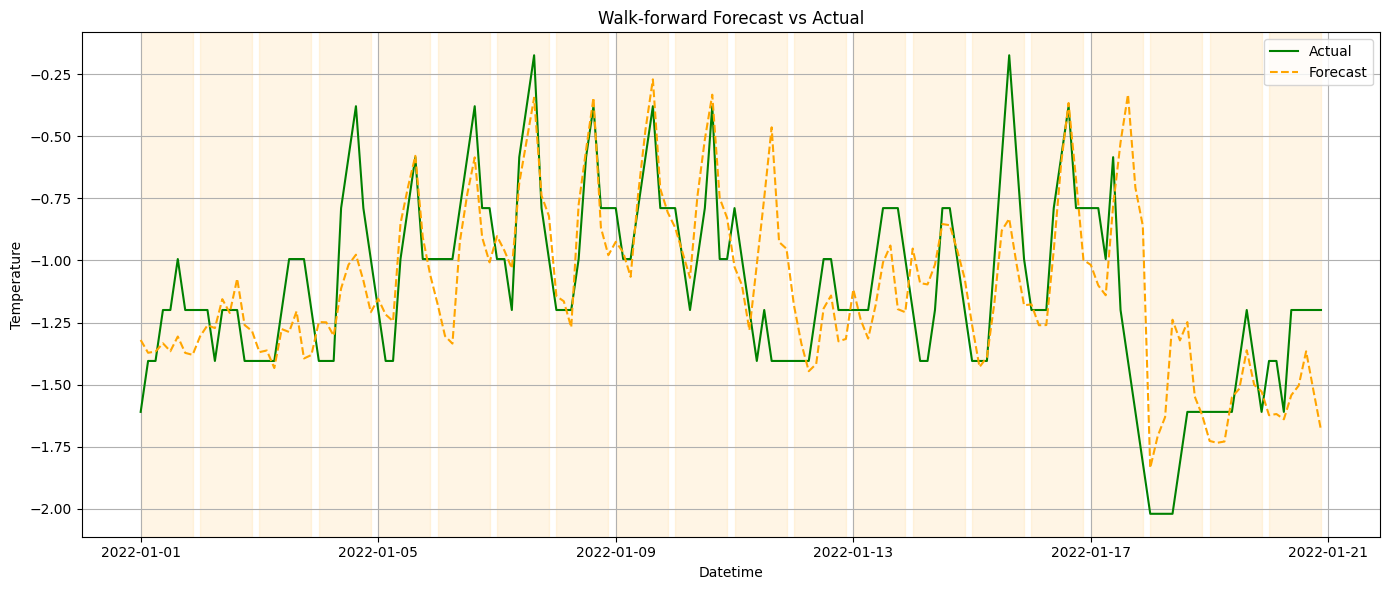

In [34]:
import matplotlib.pyplot as plt

# Assume final_forecasts and test_processed are ready
# Align forecast dates to actual test dates
final_forecasts.index = future.iloc[:len(final_forecasts)].ds.values
actual_values = future.iloc[:len(final_forecasts)]

plt.figure(figsize=(14, 6))

# Plot actual temperatures
plt.plot(actual_values.ds, actual_values.y, label='Actual', color='green')

# Plot predicted temperatures
plt.plot(final_forecasts.ds, final_forecasts['ARIMA'], label='Forecast', color='orange', linestyle='--')

for i in range(0, len(final_forecasts), 8):
    block = final_forecasts.index[i:i + 8]
    if len(block) > 0:
        start, end = block[0], block[-1]
        plt.axvspan(start, end, color='orange', alpha=0.1)

plt.title("Walk-forward Forecast vs Actual")
plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
